# CNN for Sentence Classification

### Modificaciones que se le hicieron al notebook: cargamos los embeddings, entrenamos los casos para pesos random, estáticos y no-estáticos.

### Libraries used

In [ ]:
# Tools
import os
import time
import random
import shutil
from argparse import Namespace
import matplotlib.pyplot as plt
from typing import Callable, Tuple

# Preprocessing
from nltk.tokenize import TweetTokenizer
from nltk import FreqDist
import pandas as pd
import numpy as np

# PyTorch
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence

# scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# word embeddings
from gensim.models import Word2Vec
from gensim.models.keyedvectors import Word2VecKeyedVectors

Set seeds for reproducibility

In [ ]:
args = Namespace()

args.seed = 1111
random.seed(args.seed) # python seed
np.random.seed(args.seed) # numpy seed
torch.manual_seed(args.seed) # torch seed
torch.backends.cudnn.benchmark = False # causes cuDNN to deterministically select algorithms for Neural Network operations
torch.backends.cudnn.deterministic = True # Use deterministic algorithms instead of non-deterministic where available

### Load Dataset

In [ ]:
!gdown https://drive.google.com/uc?id=1CL2rtDbi7HU1OY8JNrgIlq5TYVhgvAzZ
!unzip -qq mex-a3t.zip

Downloading...
From: https://drive.google.com/uc?id=1CL2rtDbi7HU1OY8JNrgIlq5TYVhgvAzZ
To: /content/mex-a3t.zip
100% 234k/234k [00:00<00:00, 114MB/s]


Set split hyperparameter and split data

In [ ]:
args.val_size = 0.1

In [ ]:
X_train = pd.read_csv('mex_train.txt', sep='\r\n', engine='python', header=None).loc[:,0]
y_train = pd.read_csv('mex_train_labels.txt', header=None).loc[:,0]
#.values.tolist()

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=args.val_size, random_state=args.seed)

X_test = pd.read_csv('mex_val.txt', sep='\r\n', engine='python', header=None).loc[:,0]
y_test = pd.read_csv('mex_val_labels.txt', header=None).loc[:,0]

Functions to build vocabulary

In [ ]:
def get_vocab(corpus: pd.DataFrame,
              tokenizer: Callable[[str], list],
              max_features: int) -> set:
    freq_dist = FreqDist([w.lower() for sentence in corpus\
                                    for w in tokenizer(sentence)])

    sorted_words = sortFreqDict(freq_dist)[:min(max_features-1, len(freq_dist))]
    w2idx = {word: i+1 for i, word in enumerate(sorted_words)}

    # Append <pad> token with 0 index
    sorted_words.append('<pad>')
    w2idx['<pad>'] = 0

    return set(sorted_words), w2idx

def sortFreqDict(freq_dist: FreqDist) -> list:
    freq_dict = dict(freq_dist)
    return sorted(freq_dict, key=freq_dict.get, reverse=True)

In [ ]:
# Set vocab size
args.vocab_size = 5000

tk = TweetTokenizer()
vocab, w2idx = get_vocab(X_train, tk.tokenize, args.vocab_size)

In [ ]:
print(vocab)
print(w2idx)

{'rico', 'dineral', 'pura', 'favor', 'buchón', 'puse', 'percartarme', 'navidad', '500', 'pensar', 'llore', 'use', 'fuck', 'mamaron', 'cabrones', 'rey', 'percepción', 'estuve', 'uno', 'solución', 'entrega', 'perras', 'quienes', 'madero', 'parezca', 'real', 'jodan', 'video', 'erario', '.', 'costumbre', 'cuerpecito', 'lightning', 'encantaré', 'presidente', 'pagas', 'manejan', 'allá', 'urgida', 'eterna', 'tratan', 'chingon', '😤', 'amantes', 'tengo', 'res', 'puente', 'yo', 'excepto', 'toy', 'narizones', 'izquierdo', 'compañero', 'esq', 'deseo', 'diciendo', 'critican', 'peor', 'md', 'letrero', '😊', 'damas', 'pedazo', 'recibió', 'próximo', 'frida', 'ello', 'chamarra', 'quejan', 'pi', 'espanto', 'burla', 'deslecharla', 'karen', '^', 'sacaron', 'bonita', 'tantito', 'hotel', 'tronco', 'adoptar', 'echa', 'cita', 'otoño', 'sean', 'pedas', 'pisen', 'don', 'niños', 'chingando', 'manera', 'gran', 'activo', 'prácticamente', 'mostrar', 'sonrisas', 'puede', 'queden', 'mandando', '🤘🏼', 'levanta', 'rapea'

### Define Dataset, collate_fn and Dataloader

Define Map-style Dataset (one that implements the `__getitem__()` and `__len__()` protocols) class for processing each observation in the correct format for the model

In [ ]:
class TweeterDataset(Dataset):
    def __init__(self,
                 X: pd.DataFrame,
                 y: pd.DataFrame,
                 vocab: set,
                 w2idx: dict,
                 tokenizer: Callable[[str], list],
                 max_seq_len: int):
        self.X = X
        self.y = y
        self.vocab = vocab
        self.w2idx = w2idx
        self.tokenizer = tokenizer
        self.max_seq_len = max_seq_len

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        # Get sequence of token ids
        sentence = self.X.iloc[idx]
        tokens = [self.w2idx[w] for w in self.tokenizer(sentence) if w in self.vocab]

        # Truncate sequence up to max_seq_len
        truncate_len = min(len(tokens), self.max_seq_len)
        tokens = tokens[:truncate_len]

        # Get true label
        label = self.y.iloc[idx]

        return torch.LongTensor(tokens), torch.LongTensor([label])

Define function to collate samples fetched by the sampler from the Dataset. The Dataloader will return the output of this `collate_fn` that we define.

In [ ]:
def collate_fn(batch):
    # Get X
    batch_tokens = [row[0] for row in batch]
    # Get y
    batch_labels = torch.LongTensor([row[1] for row in batch]).to(torch.float)

    # Pad with 0 (to the rigth) shorter sequences than max_seq_len
    padded_batch_tokens = pad_sequence(batch_tokens, batch_first=True)

    return padded_batch_tokens, batch_labels.unsqueeze(1)

Build Dataloaders to process batches of observations from the Datasets

In [ ]:
# Set batch size in args
args.batch_size = 64

# Num workers
args.num_workers = 0

# Maximum sequence length
args.max_seq_len = 20

In [ ]:
# Training
train_dataset = TweeterDataset(X_train, y_train, vocab, w2idx, tk.tokenize, args.max_seq_len)
train_loader = DataLoader(train_dataset,
                          batch_size=args.batch_size,
                          num_workers=args.num_workers,
                          collate_fn=collate_fn,
                          shuffle=True)

# Validation
val_dataset = TweeterDataset(X_val, y_val, vocab, w2idx, tk.tokenize, args.max_seq_len)
val_loader = DataLoader(val_dataset,
                          batch_size=args.batch_size,
                          num_workers=args.num_workers,
                          collate_fn=collate_fn,
                          shuffle=False)

# Test
test_dataset = TweeterDataset(X_test, y_test, vocab, w2idx, tk.tokenize, args.max_seq_len)
test_loader = DataLoader(test_dataset,
                          batch_size=args.batch_size,
                          num_workers=args.num_workers,
                          collate_fn=collate_fn,
                          shuffle=False)

When iterating a ```Dataloader```, the whole order of execution to get a batch is roughly the following:

1. A `Sampler` object in `batch_sampler` variable, retrieves a batch of indices.

2. For each retrieved index, get the data from the defined `Dataset` object, process all the batch samples with the defined `collate_fn` and return the result:

    ```
    for indices in batch_sampler:
        yield collate_fn([dataset[i] for i in indices])
    ```




Testing train Dataloader

In [ ]:
batch_ = next(iter(train_loader))
print(f'X_batch shape: {batch_[0].shape}')
print(f'y_batch shape: {batch_[1].shape}')

X_batch shape: torch.Size([64, 20])
y_batch shape: torch.Size([64, 1])


### Define CNN text classifier

In [ ]:
class CNNTextCls(nn.Module):
    def __init__(self, args, embeddings=None, freeze=False):
        super(CNNTextCls, self).__init__()

        if embeddings is not None:
            self.emb = nn.Embedding.from_pretrained(torch.FloatTensor(embeddings))
            if freeze:
                self.emb.weight.requires_grad=False
        else:
            self.emb = nn.Embedding(args.vocab_size, args.d)

        conv_block_list = []

        for k in args.filter_sizes:
            conv_block = nn.Sequential(
                nn.Conv1d(in_channels=args.d, out_channels=args.num_filters, kernel_size=k, stride=1),
                nn.ReLU(),
                nn.MaxPool1d(kernel_size=(args.max_seq_len-k+1))
            )
            conv_block_list.append(conv_block)

        self.conv_block_list = nn.ModuleList(conv_block_list)
        self.dropout = nn.Dropout(args.dropout)
        self.fc = nn.Linear(args.num_filters*len(args.filter_sizes), 1)

    def forward(self, x):
        '''
        B: batch size
        L: sequence length
        D: embedding dim
        C: Convolution output channels (number of filters)
        k: Convolution kernel size
        N: Number of convolution blocks

        x shape: (B, L)
        '''
        x = self.emb(x) # (B, L, D)
        x = x.transpose(1,2) # (B, D, L) conv1d expects L in last dimension

        x_filter = []
        for conv_block in self.conv_block_list: # Conv1d -> ReLU -> MaxPool1d
            x_filter.append(conv_block(x).squeeze(2)) # (B, C, L-k+1) -> ReLU -> (B, C, 1) -> (B, C) after squeeze

        x_cat = torch.cat(x_filter, dim=1) # (B, C*N)
        x = self.dropout(x_cat)
        return self.fc(x)

### Helper functions for model evaluation

In [ ]:
def model_eval(data, model, gpu=False):
    with torch.no_grad():
        preds, tgts = [], []
        for input, labels in data:
            if gpu:
                input = input.cuda()

            outputs = model(input)

            # Get prediction for Accuracy
            y_pred = y_pred = torch.round(torch.sigmoid(outputs.detach())).cpu().numpy()

            tgt = labels.numpy()
            tgts.append(tgt)
            preds.append(y_pred)

    tgts = [e for l in tgts for e in l]
    preds = [e for l in preds for e in l]

    metrics = {
        "accuracy": accuracy_score(tgts, preds),
    }

    return metrics

### Helper function to save model

In [ ]:
def save_checkpoint(state, is_best, checkpoint_path, filename="checkpoint.pt"):
    filename = os.path.join(checkpoint_path, filename)
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, os.path.join(checkpoint_path, "model_best.pt"))

### Training function

In [ ]:
def train(args, model, train_loader, val_loader, optimizer, criterion, scheduler):
    best_metric = 0
    metric_history = []
    train_metric_history = []

    for epoch in range(args.num_epochs):
        epoch_start_time = time.time()
        loss_epoch = []
        training_metrics = []
        model.train()

        for input, labels in train_loader:
            # If GPU available
            if args.use_gpu:
                input = input.cuda()
                labels = labels.cuda()

            # Forward pass
            outputs = model(input)

            loss = criterion(outputs, labels)
            loss_epoch.append(loss.item())

            # Get training metric
            preds = torch.round(torch.sigmoid(outputs.detach())).cpu().numpy()
            training_metrics.append(accuracy_score(labels.cpu().numpy(), preds))

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Get metric in training dataset
        mean_epoch_accuracy = np.mean(training_metrics)
        train_metric_history.append(mean_epoch_accuracy)

        # Get metric in validation dataset
        model.eval()
        tuning_metric = model_eval(val_loader, model, gpu=args.use_gpu)
        metric_history.append(tuning_metric['accuracy'])

        # Update scheduler
        scheduler.step(tuning_metric['accuracy'])

        # Check for metric improvement
        is_improvement = tuning_metric['accuracy'] > best_metric
        if is_improvement:
            best_metric = tuning_metric['accuracy']
            n_no_improve = 0
        else:
            n_no_improve += 1

        # Save best model if metric improved
        save_checkpoint(
            {
                "epoch": epoch + 1,
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "scheduler": scheduler.state_dict(),
                "best_metric": best_metric,
            },
            is_improvement,
            args.savedir,
        )

        # Early stopping
        if n_no_improve >= args.patience:
            print("No improvement. Breaking out of loop.")
            break

        print ('Epoch [{}/{}], Loss: {:.4f} - Train Accuracy: {:.4f} - Val Accuracy: {:.4f} - Epoch time: {:.2f} s'
            .format(epoch+1, args.num_epochs, np.mean(loss_epoch), mean_epoch_accuracy, tuning_metric['accuracy'], (time.time()- epoch_start_time)))

    return train_metric_history, metric_history

### Load embeddings

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

path_embeddings = '/content/drive/MyDrive/PLN/word2vec_col_nlp_class_spring_2023.zip'

with zipfile.ZipFile(path_embeddings, 'r') as zip_ref:
    zip_ref.extractall('/content')


In [ ]:
def cargar_embeddings(ruta_archivo):
    embeddings = {}
    with open(ruta_archivo, 'r', encoding='utf-8') as archivo:
        # Leer la primera línea para obtener el número de palabras y la dimensión de los embeddings
        num_palabras, dim_embedding = map(int, archivo.readline().split())

        # Leer cada línea y almacenar en el diccionario
        for linea in archivo:
            valores = linea.split()
            palabra = valores[0]
            coeficientes = np.asarray(valores[1:], dtype='float32')
            embeddings[palabra] = coeficientes

    return embeddings

ruta_archivo = './word2vec_col.txt'
embeddings = cargar_embeddings(ruta_archivo)

In [ ]:
args.d = 100 # Dimension of word embeddings
embedding_matrix = torch.zeros((args.vocab_size, args.d))

for i, word in enumerate(vocab):
  id = w2idx[word]
  if word in embeddings:
      embedding_matrix[id] = torch.tensor(embeddings.get(word))
  else:
      embedding_matrix[id] = torch.rand(args.d)

# embedding_layer = nn.Embedding(args.vocab_size, args.d)
# embedding_layer.weight = nn.Parameter(embedding_matrix)

# Static

### Train CNN classifier

In [ ]:
# Model hyperparameters
args.filter_sizes = [3, 4, 5]
args.num_filters = 100
args.dropout = 0.1

# Training hyperparameters
args.lr = 1e-2
args.num_epochs = 100
args.patience = 10

# Scheduler hyperparameters
args.lr_patience = 5
args.lr_factor = 0.5

# Saving directory
args.savedir = 'model'
os.makedirs(args.savedir, exist_ok=True)

# Create model
model = CNNTextCls(args, embeddings=embedding_matrix, freeze=True)

# Send to GPU
args.use_gpu = torch.cuda.is_available()
if args.use_gpu:
    model.cuda()

# Loss, Optimizer and Scheduler
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=args.lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, "max",
                patience=args.lr_patience,
                verbose=True,
                factor=args.lr_factor
            )

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [ ]:
start_time = time.time()
train_metric_history, val_metric_history = train(args, model, train_loader, val_loader, optimizer, criterion, scheduler)
print("Total training time: {:.4f} seconds".format((time.time() - start_time)))

Epoch [1/100], Loss: 1.2729 - Train Accuracy: 0.5680 - Val Accuracy: 0.6883 - Epoch time: 4.72 s
Epoch [2/100], Loss: 0.6826 - Train Accuracy: 0.6645 - Val Accuracy: 0.7477 - Epoch time: 4.99 s
Epoch [3/100], Loss: 0.5589 - Train Accuracy: 0.7161 - Val Accuracy: 0.7153 - Epoch time: 3.15 s
Epoch [4/100], Loss: 0.5304 - Train Accuracy: 0.7390 - Val Accuracy: 0.7640 - Epoch time: 2.81 s
Epoch [5/100], Loss: 0.4776 - Train Accuracy: 0.7667 - Val Accuracy: 0.7441 - Epoch time: 2.81 s
Epoch [6/100], Loss: 0.4434 - Train Accuracy: 0.7906 - Val Accuracy: 0.7748 - Epoch time: 3.27 s
Epoch [7/100], Loss: 0.4150 - Train Accuracy: 0.8078 - Val Accuracy: 0.7694 - Epoch time: 4.69 s
Epoch [8/100], Loss: 0.3940 - Train Accuracy: 0.8172 - Val Accuracy: 0.7676 - Epoch time: 4.56 s
Epoch [9/100], Loss: 0.3672 - Train Accuracy: 0.8396 - Val Accuracy: 0.7099 - Epoch time: 2.72 s
Epoch [10/100], Loss: 0.3449 - Train Accuracy: 0.8541 - Val Accuracy: 0.7712 - Epoch time: 2.74 s
Epoch [11/100], Loss: 0.3250 

In [ ]:
model.load_state_dict(torch.load('model/model_best.pt')['state_dict'])
model.eval()
test_metric = model_eval(test_loader, model, gpu=args.use_gpu)
print("\nTest Accuracy: {:.4f}".format(test_metric["accuracy"]))


Test Accuracy: 0.7338


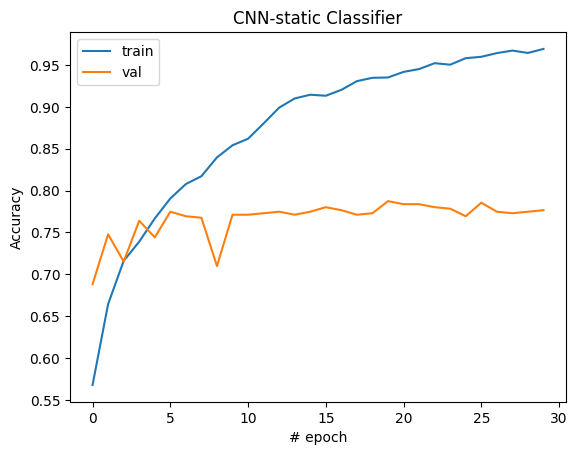

In [ ]:
plt.plot(train_metric_history, label='train')
plt.plot(val_metric_history, label='val')
plt.title('CNN-static Classifier')
plt.ylabel('Accuracy')
plt.xlabel('# epoch')
plt.legend(loc='best')
plt.savefig('static.png')
plt.show()

## Non-estatic

In [ ]:
# Create model
model = CNNTextCls(args, embeddings=embedding_matrix, freeze=False)

# Send to GPU
args.use_gpu = torch.cuda.is_available()
if args.use_gpu:
    model.cuda()

# Loss, Optimizer and Scheduler
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=args.lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, "max",
                patience=args.lr_patience,
                verbose=True,
                factor=args.lr_factor
            )

# Train
start_time = time.time()
train_metric_history, val_metric_history = train(args, model, train_loader, val_loader, optimizer, criterion, scheduler)
print("Total training time: {:.4f} seconds".format((time.time() - start_time)))

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [1/100], Loss: 1.2576 - Train Accuracy: 0.5710 - Val Accuracy: 0.6703 - Epoch time: 6.94 s
Epoch [2/100], Loss: 0.6871 - Train Accuracy: 0.6706 - Val Accuracy: 0.7441 - Epoch time: 7.52 s
Epoch [3/100], Loss: 0.5632 - Train Accuracy: 0.7178 - Val Accuracy: 0.7604 - Epoch time: 6.11 s
Epoch [4/100], Loss: 0.5008 - Train Accuracy: 0.7533 - Val Accuracy: 0.7261 - Epoch time: 3.17 s
Epoch [5/100], Loss: 0.4898 - Train Accuracy: 0.7548 - Val Accuracy: 0.7279 - Epoch time: 2.81 s
Epoch [6/100], Loss: 0.4486 - Train Accuracy: 0.7866 - Val Accuracy: 0.7171 - Epoch time: 2.83 s
Epoch [7/100], Loss: 0.4110 - Train Accuracy: 0.8092 - Val Accuracy: 0.7135 - Epoch time: 3.45 s
Epoch [8/100], Loss: 0.3942 - Train Accuracy: 0.8230 - Val Accuracy: 0.7459 - Epoch time: 5.47 s
Epoch [9/100], Loss: 0.3691 - Train Accuracy: 0.8366 - Val Accuracy: 0.7495 - Epoch time: 6.07 s
Epoch [10/100], Loss: 0.3287 - Train Accuracy: 0.8635 - Val Accuracy: 0.7459 - Epoch time: 2.83 s
Epoch [11/100], Loss: 0.3145 

In [ ]:
model.load_state_dict(torch.load('model/model_best.pt')['state_dict'])
model.eval()
test_metric = model_eval(test_loader, model, gpu=args.use_gpu)
print("\nTest Accuracy: {:.4f}".format(test_metric["accuracy"]))


Test Accuracy: 0.7013


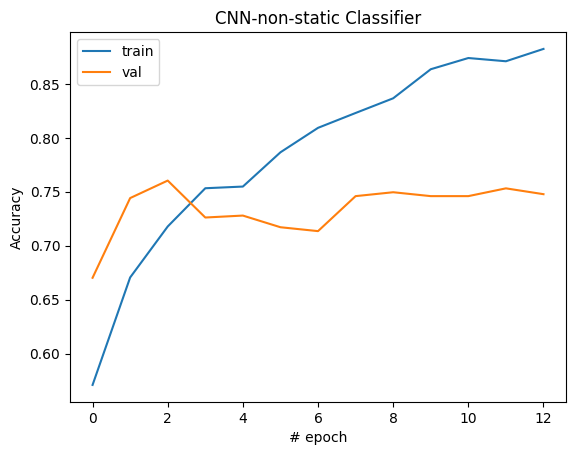

In [ ]:
plt.plot(train_metric_history, label='train')
plt.plot(val_metric_history, label='val')
plt.title('CNN-non-static Classifier')
plt.ylabel('Accuracy')
plt.xlabel('# epoch')
plt.legend(loc='best')
plt.savefig('non_static.png')
plt.show()

## Random

In [ ]:
# Create model
model = CNNTextCls(args)

# Send to GPU
args.use_gpu = torch.cuda.is_available()
if args.use_gpu:
    model.cuda()

# Loss, Optimizer and Scheduler
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=args.lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, "max",
                patience=args.lr_patience,
                verbose=True,
                factor=args.lr_factor
            )

# Train
start_time = time.time()
train_metric_history, val_metric_history = train(args, model, train_loader, val_loader, optimizer, criterion, scheduler)
print("Total training time: {:.4f} seconds".format((time.time() - start_time)))

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [1/100], Loss: 0.6615 - Train Accuracy: 0.6276 - Val Accuracy: 0.6667 - Epoch time: 4.20 s
Epoch [2/100], Loss: 0.6377 - Train Accuracy: 0.6420 - Val Accuracy: 0.6631 - Epoch time: 6.24 s
Epoch [3/100], Loss: 0.6253 - Train Accuracy: 0.6512 - Val Accuracy: 0.6793 - Epoch time: 5.26 s
Epoch [4/100], Loss: 0.6112 - Train Accuracy: 0.6660 - Val Accuracy: 0.6775 - Epoch time: 3.66 s
Epoch [5/100], Loss: 0.5917 - Train Accuracy: 0.6861 - Val Accuracy: 0.6883 - Epoch time: 3.67 s
Epoch [6/100], Loss: 0.5730 - Train Accuracy: 0.7060 - Val Accuracy: 0.6847 - Epoch time: 5.59 s
Epoch [7/100], Loss: 0.5584 - Train Accuracy: 0.7278 - Val Accuracy: 0.6973 - Epoch time: 5.99 s
Epoch [8/100], Loss: 0.5447 - Train Accuracy: 0.7317 - Val Accuracy: 0.7027 - Epoch time: 3.69 s
Epoch [9/100], Loss: 0.5250 - Train Accuracy: 0.7480 - Val Accuracy: 0.7153 - Epoch time: 3.68 s
Epoch [10/100], Loss: 0.5085 - Train Accuracy: 0.7679 - Val Accuracy: 0.7153 - Epoch time: 4.71 s
Epoch [11/100], Loss: 0.4898 

In [ ]:
model.load_state_dict(torch.load('model/model_best.pt')['state_dict'])
model.eval()
test_metric = model_eval(test_loader, model, gpu=args.use_gpu)
print("\nTest Accuracy: {:.4f}".format(test_metric["accuracy"]))


Test Accuracy: 0.7565


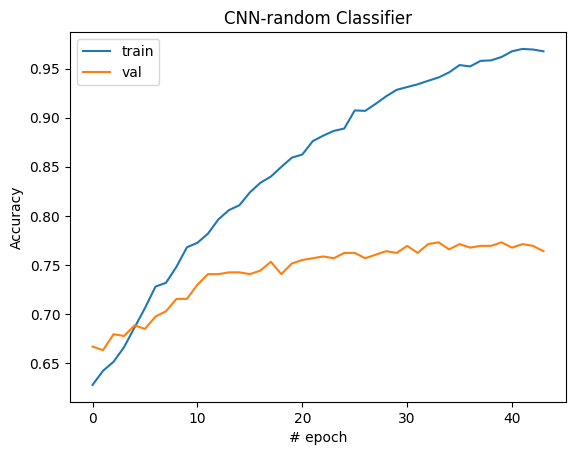

In [ ]:
plt.plot(train_metric_history, label='train')
plt.plot(val_metric_history, label='val')
plt.title('CNN-random Classifier')
plt.ylabel('Accuracy')
plt.xlabel('# epoch')
plt.legend(loc='best')
plt.savefig('random.png')
plt.show()